<a href="https://colab.research.google.com/github/kgedney/author-id-project/blob/master/author_id_CNN_CNNandLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
import keras
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
os.getcwd()

'/content'

In [0]:
os.getcwd()
path = '/Users/aprilchung/Documents/Grad School/ANLY590/author-id-project'
#os.chdir(path)

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/filtered_data.csv')

In [0]:
import re
data['body_no_urls'] = data.apply(lambda row: re.sub(r"http\S+", "<url>", row['body']), axis=1) 

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk.tokenize import word_tokenize
data['tokenized_nltk']  = data.apply(lambda row: word_tokenize(row['body_no_urls']), axis=1)

In [9]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D, LSTM

In [0]:
data['author_id'] = pd.Categorical(data.author).codes

In [18]:
x = data['tokenized_nltk'].values
y = data['author_id'].values

# create sequences
max_features = 20000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

235


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

In [20]:
x_train.shape[1]

235

CNN model from homework 

In [0]:
model_conv = Sequential()
model_conv.add(Embedding(max_features, output_dim = 30, input_length=219))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(128, 5, activation='relu'))
model_conv.add(Conv1D(128, 5, activation='relu'))
model_conv.add(GlobalMaxPooling1D())
model_conv.add(Dropout(0.2))
model_conv.add(Dense(100, activation='softmax'))

### CNN and LSTM

In [0]:
model_conv = Sequential()
model_conv.add(Embedding(max_features, output_dim = 30, input_length=235))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(128, 5, activation='relu'))
model_conv.add(MaxPooling1D(4))
model_conv.add(LSTM(100))
#model_conv.add(GlobalMaxPooling1D())

model_conv.add(Dense(100, activation='softmax'))

In [0]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.001) # speed up optimization
model_conv.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [23]:
history = model_conv.fit(x_train, y_train,
            batch_size=128,
            epochs=50,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/50
58129/58129 [==============================] - 81s 1ms/step - loss: 4.4449 - acc: 0.0280 - val_loss: 4.3068 - val_acc: 0.0452
Epoch 2/50
58129/58129 [==============================] - 80s 1ms/step - loss: 4.1651 - acc: 0.0637 - val_loss: 4.2072 - val_acc: 0.0671
Epoch 3/50
58129/58129 [==============================] - 79s 1ms/step - loss: 3.9638 - acc: 0.0927 - val_loss: 3.9844 - val_acc: 0.0923
Epoch 4/50
58129/58129 [==============================] - 79s 1ms/step - loss: 3.7970 - acc: 0.1195 - val_loss: 3.9371 - val_acc: 0.1037
Epoch 5/50
58129/58129 [==============================] - 80s 1ms/step - loss: 3.6344 - acc: 0.1486 - val_loss: 3.8069 - val_acc: 0.1258
Epoch 6/50
58129/58129 [==============================] - 79s 1ms/step - loss: 3.4755 - acc: 0.1787 - val_loss: 3.7678 - val_acc: 0.1374
Epoch 7/50
58129/58129 [==============================] - 79s 1ms/step - loss: 3.3360 - acc: 0.2081 - val_loss: 3.6903 - val_acc

In [26]:
model_conv.evaluate(x_test, y_test)

14533/14533 [==============================] - 28s 2ms/step


[4.218580412502128, 0.23615220532786088]

In [0]:
y_pred1 = model_conv.predict(x_test)

In [56]:
def topk_acc(y_test, y_pred, k):
  return keras.backend.eval(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred, k=k)) # force it to evaluate

[(k, topk_acc(y_test, y_pred1, k=k)) for k in range(1, 10)]

[(1, 0.2361522),
 (2, 0.3086768),
 (3, 0.35594854),
 (4, 0.39695865),
 (5, 0.43246403),
 (6, 0.4644602),
 (7, 0.48943782),
 (8, 0.5129705),
 (9, 0.5325122)]

In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred1 = model_conv.predict_classes(x_test)

cm = confusion_matrix(y_test, y_pred1) #only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies1 = cm.diagonal()

In [89]:
print(accuracies1.max())
print(accuracies1.argmax())
print(data[['author', 'body']][data['author_id'] == 1][0:5])

0.6626506024096386
1
        author                                               body
28935  7omdogs  Get outta here with your “thinking things thro...
28936  7omdogs  He nearly always does on stuff like this. Its ...
28937  7omdogs  Apparently he felt so bad that he sent flowers...
28938  7omdogs  I think it’s more of a no one wants their name...
28939  7omdogs  It was the main promo song for the first HHH V...


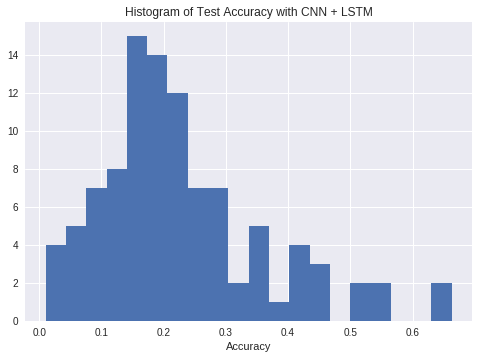

In [100]:
plt.hist(accuracies1, bins=20)
plt.title('Histogram of Test Accuracy with CNN + LSTM')
plt.xlabel('Accuracy')
plt.show()


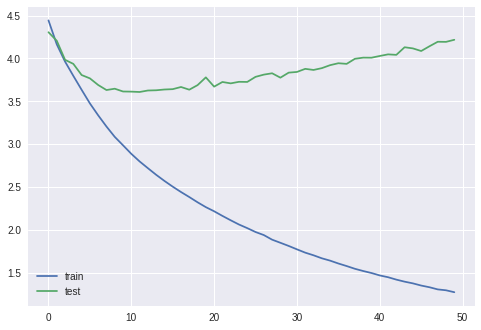

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='lower left')



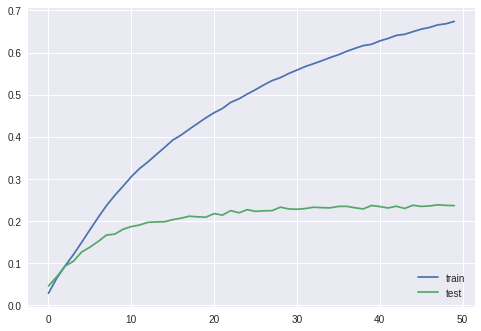

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train', 'test'], loc='lower right')

In [0]:
model_conv2 = Sequential()
model_conv2.add(Embedding(max_features, output_dim = 30, input_length=235))
model_conv2.add(Dropout(0.2))
model_conv2.add(Conv1D(128, 5, activation='relu'))
model_conv2.add(Conv1D(128, 5, activation='relu'))
model_conv2.add(GlobalMaxPooling1D())
model_conv2.add(Dropout(0.2))
model_conv2.add(Dense(100, activation='softmax'))

In [0]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.001) # speed up optimization
model_conv2.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [37]:
history2 = model_conv2.fit(x_train, y_train,
            batch_size=128,
            epochs=50,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/50
58129/58129 [==============================] - 11s 189us/step - loss: 4.4411 - acc: 0.0266 - val_loss: 4.2789 - val_acc: 0.0555
Epoch 2/50
58129/58129 [==============================] - 10s 173us/step - loss: 4.1952 - acc: 0.0623 - val_loss: 4.1003 - val_acc: 0.0793
Epoch 3/50
58129/58129 [==============================] - 10s 174us/step - loss: 4.0135 - acc: 0.0919 - val_loss: 3.9297 - val_acc: 0.1082
Epoch 4/50
58129/58129 [==============================] - 10s 175us/step - loss: 3.8323 - acc: 0.1221 - val_loss: 3.8113 - val_acc: 0.1305
Epoch 5/50
58129/58129 [==============================] - 10s 174us/step - loss: 3.6767 - acc: 0.1495 - val_loss: 3.7128 - val_acc: 0.1539
Epoch 6/50
58129/58129 [==============================] - 10s 174us/step - loss: 3.5397 - acc: 0.1749 - val_loss: 3.6347 - val_acc: 0.1652
Epoch 7/50
58129/58129 [==============================] - 10s 175us/step - loss: 3.4044 - acc: 0.2015 - val_loss: 3.

In [38]:
model_conv2.evaluate(x_test,y_test)

14533/14533 [==============================] - 2s 106us/step


[4.028622815263318, 0.24378999518337577]

In [0]:
y_pred = model_conv2.predict(x_test)

In [61]:
def topk_acc(y_test, y_pred, k):
  return keras.backend.eval(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred, k=k)) # force it to evaluate

[(k, topk_acc(y_test, y_pred, k=k)) for k in range(1, 10)]

[(1, 0.24379),
 (2, 0.32395238),
 (3, 0.37893072),
 (4, 0.42117938),
 (5, 0.45482695),
 (6, 0.48420835),
 (7, 0.51063097),
 (8, 0.5323746),
 (9, 0.5548063)]

In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = model_conv2.predict_classes(x_test)

cm = confusion_matrix(y_test, y_pred) #only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies2 = cm.diagonal()

In [87]:
print(accuracies2.max())
print(accuracies2.argmax())
print(data[['author', 'body']][data['author_id'] == 68][0:5])

0.696551724137931
68
      author                                               body
9346  djphan  Kansas is an underrated pickup opportunity... ...
9347  djphan  how can i point to their argument without usin...
9348  djphan  i did.. i see the subsequent comments... and t...
9349  djphan  i literally quoted it in my first reply...  \n...
9350  djphan  youre saying that clinton did it herself... th...


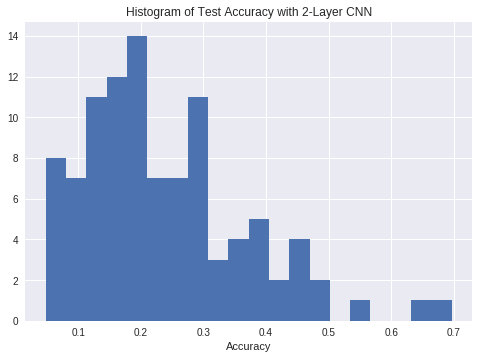

In [99]:
plt.hist(accuracies2, bins=20)
plt.title('Histogram of Test Accuracy with 2-Layer CNN')
plt.xlabel('Accuracy')
plt.show()


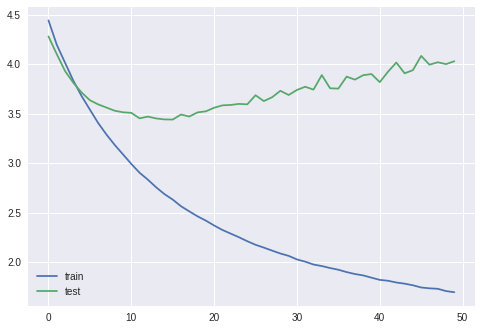

In [39]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train', 'test'], loc='lower left')

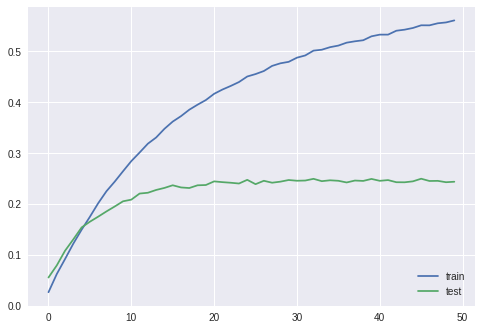

In [40]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.legend(['train', 'test'], loc='lower right')